In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.models as models

from skimage.io import imread, imshow
from mimic_constants import *
from trulens.nn.quantities import ClassQoI
from trulens.nn.models import get_model_wrapper
from trulens.visualizations import MaskVisualizer
from trulens.nn.attribution import InputAttribution, IntegratedGradients

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message="__array_wrap__ must accept context and return_scalar arguments")
os.environ['TRULENS_BACKEND'] = 'pytorch'
%matplotlib inline

In [2]:
def get_bartending_filenames(stats_df, areas=significant_variables_areas):
    bar_has_attention = set()
    for key in list(areas.keys())[1:]:
        non_zero_filenames_for_area = stats_df[(stats_df['area'] == key) & (stats_df['mean'] > 0)]['filename'].values.tolist()
        bar_has_attention.update(non_zero_filenames_for_area)
    return bar_has_attention

In [3]:
image_type = 'blank'
age = 80
gender = None
race = None
disease = 1
seed = 42
bartends_saliency = False
bartends_ig = True

In [4]:
order, suffix = get_barcode_order_info(order=None, no_bars=False, nan=False)
preproc_dir = get_preproc_subpath(image_type, suffix)
checkpoint_file = get_checkpoint_path(image_type, suffix, run_id=k_fold_run_id[image_type])
exp_dir = home_out_dir / f"cross-val/densenet-{image_type}-{suffix}-{'idp'}/"

In [5]:
# read test csv
df = pd.read_csv(exp_dir / f'test.csv').drop('Unnamed: 0', axis=1)

# standardize + add paths
df = standardize_mimic_ethnicity(df)
df = df_add_preproc_path_col(df, nb_group_dir, preproc_dir)
df['path_saliency_mask'] = df['path_preproc'].apply(lambda path_preproc: (get_mask_save_dir_path(image_type, suffix, 'saliency', 'Cardiomegaly') / os.path.basename(path_preproc).replace('.jpg', '.npy')).as_posix())
df['path_ig_mask'] = df['path_preproc'].apply(lambda path_preproc: (get_mask_save_dir_path(image_type, suffix, 'ig', 'Cardiomegaly') / os.path.basename(path_preproc).replace('.jpg', '.npy')).as_posix())

# add model predictions
df_pred_xray = pd.read_csv(k_fold_test_pred_csv_path['xray'])
df_pred_noise = pd.read_csv(k_fold_test_pred_csv_path['noise'])
df_pred_blank = pd.read_csv(k_fold_test_pred_csv_path['blank'])
df['xray_prob'] = df_pred_xray['class_0']
df['xray_pred'] = (df_pred_xray['class_0'] > 0.5).astype(int)
df['noise_prob'] = df_pred_noise['class_0']
df['noise_pred'] = (df_pred_noise['class_0'] > 0.5).astype(int)
df['blank_prob'] = df_pred_blank['class_0']
df['blank_pred'] = (df_pred_blank['class_0'] > 0.5).astype(int)

# filter df based on chosen parameters
if bartends_saliency:
    saliency_stats_df = get_mask_stats_csv(image_type, suffix, 'saliency', 'Cardiomegaly')  
    non_zero_saliency_paths = get_bartending_filenames(saliency_stats_df)
    df = df[df['path_saliency_mask'].isin(non_zero_saliency_paths)]

if bartends_ig:
    ig_stats_df = get_mask_stats_csv(image_type, suffix, 'ig', 'Cardiomegaly')
    non_zero_ig_paths = get_bartending_filenames(ig_stats_df)
    df = df[df['path_ig_mask'].isin(non_zero_ig_paths)]

if age:
    df = df[(df['anchor_age'] <= age + 5) & (df['anchor_age'] >= age - 5)]

if gender:
    df = df[df['gender'] == gender]

if race:
    df = df[df['ethnicity'] == race]

if disease:
    df = df[df['Cardiomegaly'] == disease]

if len(df) == 0:
    print('No relevant examples found in the test set.')
else:
    print(f'{len(df)} relevant examples found in the test set. Picking one at random for visualization.')
    df = df.sample(n=1, random_state=seed)
    df['age_val']      = df['anchor_age']
    path_saliency_mask = df['path_saliency_mask'].values[0]
    path_preproc       = df['path_preproc'].values[0]
    path_ig_mask       = df['path_ig_mask'].values[0]

94 relevant examples found in the test set. Picking one at random for visualization.


In [6]:
df[significant_variables]

,age_val,Chloride_mean,RR_mean,Urea_Nitrogren_mean,Magnesium_mean,Glucose_mean,Phosphate_mean,Hematocrit_mean
237,84,103.75,19.102041,32.166667,2.05,132.583333,3.075,32.375


In [7]:
df[['Cardiomegaly', 'xray_prob', 'xray_pred', 'noise_prob', 'noise_pred', 'blank_prob', 'blank_pred']]

,Cardiomegaly,xray_prob,xray_pred,noise_prob,noise_pred,blank_prob,blank_pred
237,1,0.99926,1,0.883633,1,0.803117,1


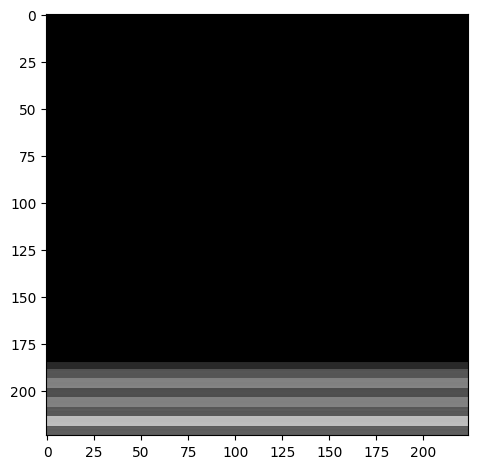

In [8]:
img_np = imread(path_preproc)
x_pp = torch.from_numpy(img_np.astype(np.float32))
x_pp = x_pp.permute(2, 0, 1).unsqueeze(0)
x_np = x_pp.numpy()
imshow(img_np)

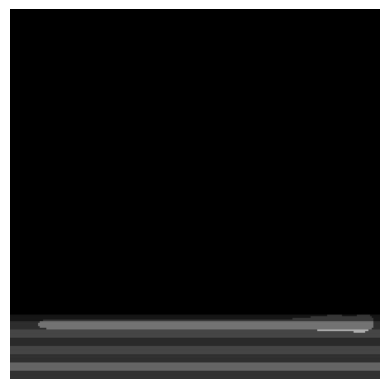

In [46]:
attrs_input_saliency = np.expand_dims(np.load(path_saliency_mask), axis=0)
masked_image_saliency = MaskVisualizer(blur=5, threshold=0.9, masked_opacity=0.4)(attrs_input_saliency, x_np)

In [69]:
# Define areas of interest
areas = {
    f'{image_type}': slice(None, 185),
    'age_bar': slice(185, 190),
    'chloride_bar': slice(190, 194),
    'rr_bar': slice(194, 198),
    'urea_bar': slice(198, 202),
    'nitrogren_bar': slice(202, 207),
    'magnesium_bar': slice(207, 211),
    'glucose_bar': slice(211, 215),
    'phosphate_bar': slice(215, 220),
    'hematocrit_bar': slice(220, 224),
}

from scipy.ndimage import gaussian_filter
def normalize(attributions, blur=None, threshold=None, masked_opacity=0.0) -> np.ndarray:
    """
    Normalize the attributions to be in the range [0, 1], and then threshold them based on %tile
    """
    # Blur the attributions so the explanation is smoother.
    if blur is not None:
        attributions = [gaussian_filter(a, blur) for a in attributions]
    
    # min-max normalization
    attributions = [a - a.min() for a in attributions]
    attributions = [
        0. * a if a.max() == 0. else a / a.max() for a in attributions
    ]
    
    # Threshold the attributions to create a mask.
    masks = None
    if threshold is not None:
        percentiles = [
            np.percentile(a, 100 * threshold) for a in attributions
        ]
        masks = np.array(
            [
                np.where(a > p, a, masked_opacity)
                for a, p in zip(attributions, percentiles)
            ]
        )
    else:
        masks = np.array(attributions)
    return masks

def foo(mask, s):
    area_data = mask[:, s, :].flatten()
    non_zero = area_data[area_data != 0]
    #print(non_zero.mean())
    total_attn_map_area = np.sum(mask != 0)
    #print(total_attn_map_area)
    attn_map_area = np.sum(area_data != 0)
    #print(attn_map_area)
    #print(attn_map_area / total_attn_map_area)
    print(non_zero.mean(), non_zero.mean() * (attn_map_area / total_attn_map_area))

In [70]:
masks = normalize(attrs_input_saliency, blur=0, threshold=0.9, masked_opacity=0.0)
mask = masks[0]

foo(mask, areas['blank'])
foo(mask, areas['age_bar'])
foo(mask, areas['chloride_bar'])
foo(mask, areas['rr_bar'])

0.60046333 0.023818957267296794
0.6103365 0.06756036786330229
0.6161895 0.06535882632856424
0.64562684 0.05835832229497805


In [71]:
masks = normalize(attrs_input_saliency, blur=3, threshold=0.9, masked_opacity=0.0)
mask = masks[0]

foo(mask, areas['blank'])
foo(mask, areas['age_bar'])
foo(mask, areas['chloride_bar'])
foo(mask, areas['rr_bar'])

0.79512495 0.04933718676091802
0.819711 0.09819654822628467
0.86324656 0.20141073227151846
0.8558624 0.19872667875365782


In [68]:
masks = normalize(attrs_input_saliency, blur=5, threshold=0.9, masked_opacity=0.0)
mask = masks[0]

foo(mask, areas['blank'])
foo(mask, areas['age_bar'])
foo(mask, areas['chloride_bar'])
foo(mask, areas['rr_bar'])

0.88110995 0.12747022161628993
0.9083611 0.29106747718329357
0.92299044 0.4714513358277113
0.91455626 0.02205148354399628


In [10]:
#for blur in range(0, 5):
#    masked_image_saliency = MaskVisualizer(blur=blur, threshold=0.9, masked_opacity=0.4)(attrs_input_saliency, x_np, output_file=f'/home/ays124/mimic/blank_example_blur_{blur}.png')

In [11]:
image_type_2, image_type_3 = list(set(['xray', 'noise', 'blank']) - set([image_type]))
path_preproc_2          = path_preproc.replace(image_type, image_type_2)
path_preproc_3          = path_preproc.replace(image_type, image_type_3)
path_saliency_mask_2    = path_saliency_mask.replace(image_type, image_type_2)
path_saliency_mask_3    = path_saliency_mask.replace(image_type, image_type_3)
path_ig_mask_2          = path_ig_mask.replace(image_type, image_type_2)
path_ig_mask_3          = path_ig_mask.replace(image_type, image_type_3)

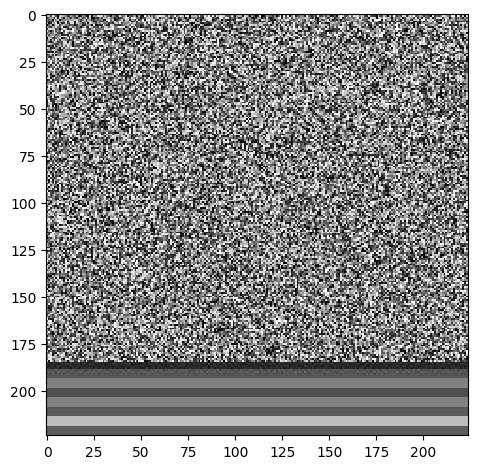

In [12]:
img_np_2 = imread(path_preproc_2)
x_pp_2 = torch.from_numpy(img_np_2.astype(np.float32))
x_pp_2 = x_pp_2.permute(2, 0, 1).unsqueeze(0)
x_np_2 = x_pp_2.numpy()
imshow(img_np_2)

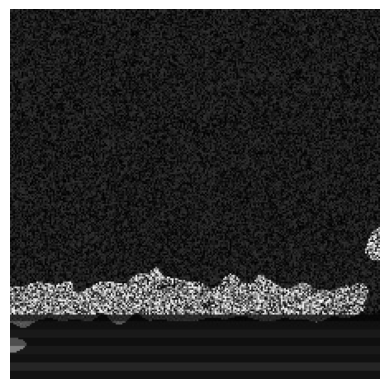

In [13]:
attrs_input_saliency_2 = np.expand_dims(np.load(path_saliency_mask_2), axis=0)
masked_image_saliency_2 = MaskVisualizer(blur=5, threshold=0.9, masked_opacity=0.2)(attrs_input_saliency_2, x_np_2)

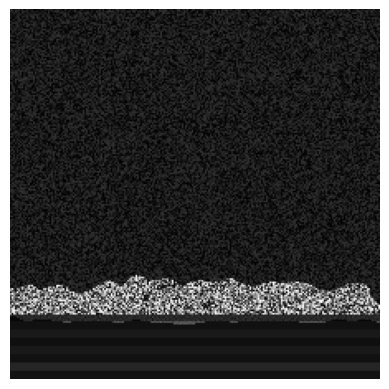

In [14]:
attrs_input_ig_2 = np.expand_dims(np.load(path_ig_mask_2), axis=0)
masked_image_ig_2 = MaskVisualizer(blur=5, threshold=0.9, masked_opacity=0.2)(attrs_input_ig_2, x_np_2)

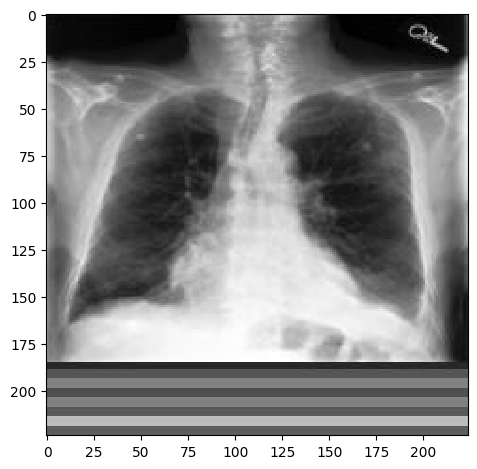

In [15]:
img_np_3 = imread(path_preproc_3)
x_pp_3 = torch.from_numpy(img_np_3.astype(np.float32))
x_pp_3 = x_pp_3.permute(2, 0, 1).unsqueeze(0)
x_np_3 = x_pp_3.numpy()
imshow(img_np_3)

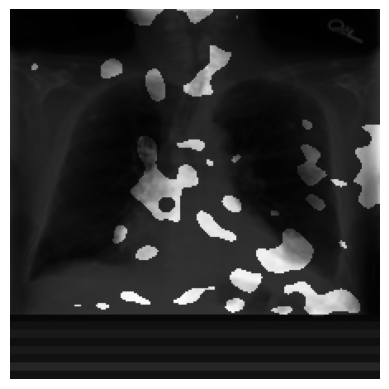

In [16]:
attrs_input_saliency_3 = np.expand_dims(np.load(path_saliency_mask_3), axis=0)
masked_image_saliency_3 = MaskVisualizer(blur=5, threshold=0.9, masked_opacity=0.2)(attrs_input_saliency_3, x_np_3)

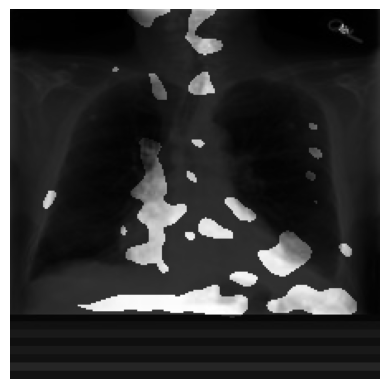

In [17]:
attrs_input_ig_3 = np.expand_dims(np.load(path_ig_mask_3), axis=0)
masked_image_ig_3 = MaskVisualizer(blur=5, threshold=0.9, masked_opacity=0.2)(attrs_input_ig_3, x_np_3)